In [1]:
!pip install grakel
!pip install POT
!pip install tqdm

You should consider upgrading via the '/Users/shoki/.pyenv/versions/3.7.5/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/shoki/.pyenv/versions/3.7.5/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/shoki/.pyenv/versions/3.7.5/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from tqdm import tqdm
from data_generator import data_generator
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

import os
import sys
import numpy as np

In [3]:
""" A function to ensure gram matrix is psd """
def ensure_psd(K, tol=1e-8):
    # Helper function to remove negative eigenvalues
    # from numpy.linalg import eigh
    w, v = np.linalg.eigh(K)
    if (w<-tol).sum() >= 1:
        neg = np.argwhere(w<-tol)
        w[neg] = 0
        Xp = v.dot(np.diag(w)).dot(v.T)
        return Xp
    else:
        return K


def evaluate_maximum_performance(D, y, distance_method=False, Krein=False):
        sfolder = StratifiedKFold(n_splits=10, shuffle=True)
        mean_accuracies = []
        for i in range(10): # 10 times
            accuracy_scores = []
            for train_index, test_index in sfolder.split(D, y): # 10-fold
                best_acc =0
                Gram_list = []
                if distance_method == True:
                    # gamma_list
                    for gamma in [1, 0.1, 0.01, 0.001, 0.0001]:
                        Gram_list.append(np.exp(-gamma*D))
                else:
                    Gram_list.append(D)
                
                for Gram in Gram_list:
                    X_train, y_train, X_test, y_test = data_generator(y, Gram, train_index, test_index)
                    if Krein == True:
                        X_train = ensure_psd(X_train)
                    for c in [0.1, 1, 10, 100, 1000]:
                        gs = SVC(C=c, kernel='precomputed').fit(X_train, y_train)
                        y_pred = gs.predict(X_test)
                        acc = accuracy_score(y_test, y_pred)
                        if acc > best_acc:
                            best_acc = acc
                accuracy_scores.append(best_acc)

            mean_accuracies.append(np.mean(accuracy_scores))
        
        mean_acc = np.mean(mean_accuracies) * 100
        std = np.std(mean_accuracies) * 100
        print('Accuracy: {:2.2f} +- {:2.2f}'.format(mean_acc, std))
        return mean_acc, std

In [4]:
# seed
np.random.seed(seed=42)
# number of WL iteration
h = 7
# dataset
d_name = "MUTAG"

# WL subtree kernel

In [5]:
from Kernels.WL import WLkernel
from grakel.datasets import fetch_dataset

dataset = fetch_dataset(d_name, verbose=False)
G, y = dataset.data, dataset.target
WL_mean_acc_list = []
WL_std_list =[]

for current_h in range(1, h+1):
    wlk = WLkernel(current_h)
    D = wlk.fit_transform(G)
    print(f"WL iteration {current_h}. ", end='')
    mean_acc, std = evaluate_maximum_performance(D, y)
    WL_mean_acc_list.append(mean_acc)
    WL_std_list.append(std)

WL iteration 1. Accuracy: 88.87 +- 0.85
WL iteration 2. Accuracy: 87.45 +- 1.07
WL iteration 3. Accuracy: 88.49 +- 1.26
WL iteration 4. Accuracy: 86.87 +- 1.10
WL iteration 5. Accuracy: 86.71 +- 1.26
WL iteration 6. Accuracy: 85.67 +- 1.14
WL iteration 7. Accuracy: 86.51 +- 1.00


# WWL kernel

In [6]:
from Kernels.WWL import *
from Kernels.utilities import read_labels

data_path = os.path.join("./Kernels/data_for_WWL", d_name)
label_sequences = compute_wl_embeddings_discrete(data_path, h)
wasserstein_distances = compute_wasserstein_distance(label_sequences, h, sinkhorn=False, discrete=True)
label_file = os.path.join(data_path, "Labels.txt")
y = np.array(read_labels(label_file))
WWL_mean_acc_list = []
WWL_std_list =[]

for current_h in range(1, h+1):
    D = wasserstein_distances[current_h]
    print(f"WL iteration {current_h}. ", end='')
    mean_acc, std = evaluate_maximum_performance(D, y, distance_method=True)
    WWL_mean_acc_list.append(mean_acc)
    WWL_std_list.append(std)

Iteration 0: done.
Iteration 1: done.
Iteration 2: done.
Iteration 3: done.
Iteration 4: done.
Iteration 5: done.
Iteration 6: done.
Iteration 7: done.
WL iteration 1. Accuracy: 90.73 +- 0.93
WL iteration 2. Accuracy: 89.36 +- 0.87
WL iteration 3. Accuracy: 88.87 +- 0.79
WL iteration 4. Accuracy: 88.85 +- 0.58
WL iteration 5. Accuracy: 87.80 +- 1.12
WL iteration 6. Accuracy: 88.26 +- 1.06
WL iteration 7. Accuracy: 87.68 +- 0.97


# WWLS kernel (Ours)

In [7]:
sys.path.append("../WWLS")
from WWLS import WWLS
from dataset_loader import load_dataset
from graph_data import Graph

dataset = load_dataset(d_name)
graphs = [Graph(data) for data in dataset]
y = [graph.y for graph in graphs]
WWLS_mean_acc_list = []
WWLS_std_list =[]

for current_h in range(1, h+1):
    wwls = WWLS(current_h)
    # graph level features
    gf = [wwls.embedding(i, graph) for i, graph in enumerate(tqdm(graphs, desc='Building WL subtrees'))] 
    sparse_gf = wwls.to_sparse(gf)
    D = wwls.compute_distance_matrices(sparse_gf, len(y))
    print(f"WL iteration {current_h}. ", end='')
    mean_acc, std = evaluate_maximum_performance(D, y, distance_method=True)
    WWLS_mean_acc_list.append(mean_acc)
    WWLS_std_list.append(std)

Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 8409.36it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:21<00:00, 821.16i


WL iteration 1. Accuracy: 92.24 +- 0.63


Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 3925.34it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:19<00:00, 882.59i


WL iteration 2. Accuracy: 91.50 +- 0.79


Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 6903.42it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:17<00:00, 984.74i


WL iteration 3. Accuracy: 92.41 +- 0.62


Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 5329.27it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:20<00:00, 876.39i


WL iteration 4. Accuracy: 91.34 +- 0.78


Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 4922.25it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:22<00:00, 767.95i


WL iteration 5. Accuracy: 91.39 +- 0.94


Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 3850.71it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:21<00:00, 824.23i


WL iteration 6. Accuracy: 90.20 +- 0.56


Converting to sparse graph features: 100%|██| 188/188 [00:00<00:00, 2979.21it/s]
Computing graph Wasserstein distances: 100%|█| 17578/17578 [00:22<00:00, 765.72i


WL iteration 7. Accuracy: 90.98 +- 0.72


# Visualize results

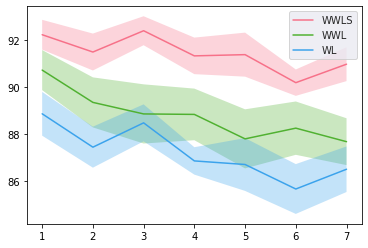

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)

mean_list = [WWLS_mean_acc_list, WWL_mean_acc_list, WL_mean_acc_list]
std_lit = [WWLS_std_list, WL_std_list, WWL_std_list]
label_list = ["WWLS", "WWL", "WL"]

with sns.axes_style("darkgrid"):
    WL_iterations = list(range(1,h+1))
    for i in range(3):
        x = np.array(mean_list[i])
        std = np.array(std_lit[i])
        ax.plot(WL_iterations, x, label=label_list[i], color=clrs[i])
        ax.fill_between(WL_iterations, x-std, x+std ,alpha=0.3, facecolor=clrs[i])
    ax.legend()
